# Анализ рынка продаж компьютерных игр

**Заказчик**

Интернет-магазин по продаже компьютерных игр



**Цель проекта**

На основе данных из открытых источников выявить закономерности, определяющие успешность игр.

В ходе анализа необходимо проверить две гипотезы:

- Средние пользовательские рейтинги платформ Xbox One  и PC одинаковые;

- Средние пользовательские рейтинги жанров Action (англ. "действие", экшен-игры) и Sports(англ. "спортивные соревнования") разные.


Исследование позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


**Входные данные**

Исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы за 2016 год.


**Ход исследования**

Исследование пройдёт в четыре этапа:

*    Обзор данных;
*    Предобработка данных, включая дополнительные расчеты;
*    Анализ данных;
*    Проверка гипотез.

## Обзор данных

In [1]:
# импорт библиотек
from scipy import stats as st
from math import factorial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# чтение файла с данными и сохранение в df
games = pd.read_csv('games.csv')

In [3]:
# обзор датафрейма games
games.info()
display(games)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Мы видим, что датафрейм содержит одиннадцать столбцов. Согласно документации:

- `Name` - название игры
- `Platform` - платформа
- `Year_of_Release` - год выпуска
- `Genre` - жанр игры
- `NA_sales` - продажи в Северной Америке (млн. проданных копий)
- `EU_sales` - продажи в Европе (млн. проданных копий)
- `JP_sales` - продажи в Японии (млн. проданных копий)
- `Other_sales` - продажи в других странах (млн. проданных копий)
- `Critic_Score` - оценка критиков (максимум 100 баллов)
- `User_score` - оценка пользователей (максимум 10 баллов)
- `Rating` - возрастной рейтинг организации ESRB (англ. Entertainment Spftware Rating Board)


**Выводы**

Мы ознакомились с таблицей. Заметно, что тип данных в столбцах не всегда корректный (например, пользовательский рейтинг с типом `object` или год релиза с типом `float`). Так же нужно проверить данные на наличие дубликатов, по возможности, заполнить пропуски  и сгуппировать данные для наглядности.

Приступаем к предобработке данных.

## Предобработка данных

Приведем наименования столбцов к "хорошему стилю", т.е. к нижнему регистру.

In [4]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

У года релиза изменим тип на цельночисленный, подсчитаем пропуски, и , если их будет сравнительно мало - удалим.

In [5]:
display(games['year_of_release'].isna().sum())    # кол-во пропусков
games['year_of_release'].isna().sum()/ len(games['year_of_release'])    # доля пропусков

269

0.01609332934489979

In [6]:
games = games.dropna(subset=['year_of_release'])    # удаляем стоки 
games['year_of_release'] = games['year_of_release'].astype('int')    # меняем тип данных на цельночисленный
games['year_of_release'].unique()

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983])

### Дубликаты

Найдем дубликаты по трем столбцам `name`, `platform`, `year_of_release`  и удалим их.

In [7]:
display(games.loc[games.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)])
games = games.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first')    # удаляем дубль

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


In [8]:
games = games.loc[games['name'].notnull()]    # удаляем строки с незаполненным значением name

Проверим, нет ли у нас случаев, когда в рамках одной платформы есть повторы названий.

In [9]:
games[games.groupby(games.name + games.platform)['name'].transform('count') > 1].sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T


Во всех случаях -  разные годы релиза, оставляем.

### `rating`

In [10]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

_Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. ESRB была основана в 1994 году ассоциацией Interactive Digital Software Association (современное название — «Entertainment Software Association»). К началу 2003 года рейтинги ESRB получили более 8000 продуктов от 350 издателей._

`EC — Early Childhood` «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры; Устаревшая градация.

`E — Everyone` «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первоначально `K-A` ("Kids to Adults");
 
`E10+ — Everyone 10+` «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови;


`T — Teen` «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики;

`M — Mature` «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории;

`AO — Adults Only` Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое, а также сцены с обнажением;

`RP — Rating Pending` Рейтинг ожидается.


Таким образом значение рейтинга `K-A`  и `EC` меняем на `E`. 

In [11]:
games.loc[games['rating'] == 'K-A', 'rating'] = 'E'
games.loc[games['rating'] == 'EC', 'rating'] = 'E'

In [12]:
# кол-во пропусков
games.rating.isna().sum()

6676

С учетом того, что ESRB была основана в 1994 году, а выгрузке присутствуют игры с 1980 года, можно предположить, что отсутствие рейтинга  - это нормально. 

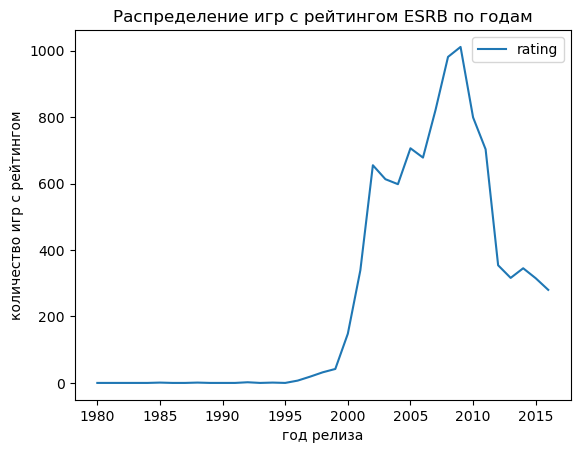

In [13]:
plots = games.groupby('year_of_release')['rating'].count().reset_index().plot(x='year_of_release')
plt.xlabel('год релиза')
plt.ylabel('количество игр с рейтингом')
plt.title('Распределение игр с рейтингом ESRB по годам')
plt.show()

Да, как мы видим на графике, количество игры, которым был присвоен рейтинг увеличиваетя после 1995 года.

Пропуски заполним соответсвующим значением "unrated".

In [14]:
games['rating'] = games['rating'].fillna('unrated')

### `critic_scores`, `users_scores`

In [15]:
games['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [16]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Мы видим значение `tbd`(англ. To Be Determined, то есть "Будет определено"). Для приведения столбца к типу `float` заменяем его пропусками.

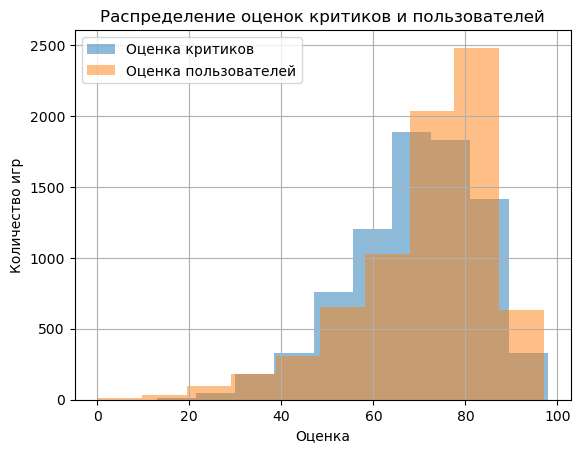

In [17]:
games.user_score.replace('tbd', np.nan, inplace=True)
games['user_score'] = games['user_score'].astype('float')

fig, ax = plt.subplots()
games.critic_score.hist(ax=ax, label='Оценка критиков',alpha=0.5)
(games.user_score*10).hist(ax=ax, label='Оценка пользователей', alpha=0.5)
ax.legend(loc='upper left')
ax.set_xlabel('Оценка')
ax.set_ylabel('Количество игр')
ax.set_title('Распределение оценок критиков и пользователей')
plt.alpha=0.5
plt.show()

В общем и целом, оценки сопадают. При это заметно, что разброс оценок у пользователей шире. Кажется логичным, что профессиональные критики не могут позволить себе впадать в крайность.

### `total_sales`

Добавим к таблице еще один столбец с суммарными продажами по всем регионам.

In [18]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [19]:
games.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unrated,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unrated,31.38


In [20]:
games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']].describe()

,na_sales,eu_sales,jp_sales,other_sales,total_sales
count,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000
mean,0.264028,0.145939,0.078492,0.047597,0.536055
std,0.818400,0.506731,0.311109,0.188011,1.558828
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.060000
50%,0.080000,0.020000,0.000000,0.010000,0.170000
75%,0.240000,0.110000,0.040000,0.030000,0.470000
max,41.360000,28.960000,10.220000,10.570000,82.540000


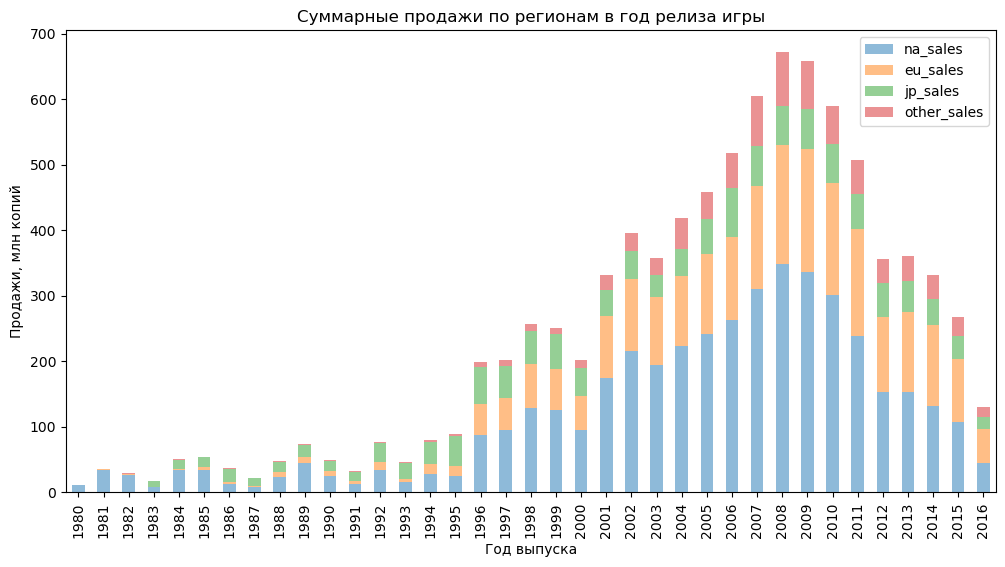

In [21]:
fig, ax = plt.subplots()

(games
 .groupby('year_of_release')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]
 .agg('sum')
 .plot(kind='bar',stacked=True, ax=ax, figsize=(12,6), alpha=0.5))

ax.set_title('Суммарные продажи по регионам в год релиза игры')
ax.set_ylabel('Продажи, млн копий')
ax.set_xlabel('Год выпуска')
plt.show()

Рынок в Северной Америке - самый большой, далее идет Европа. Рынок игр Японии сопоставим по продажам со всеми остальными ('other') странами.

## Анализ продаж (EDA)

### год выпуска

Посмотрим, сколько игр выпускалось в разные годы: построим свод с количеством игр по платформам и годам. 

In [22]:
games_years = games.pivot_table(index = 'platform', 
                                columns = 'year_of_release', 
                                values = 'name', 
                                aggfunc='count',
                                fill_value=0,
                                margins=True
                               ).reset_index()
                               
pd.set_option('display.max_columns', None)
games_years

year_of_release,platform,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,All
0,2600,9,46,36,11,1,1,2,6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116
1,3DO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
2,3DS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116,93,91,80,86,46,512
3,DC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,14,20,8,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,52
4,DS,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,118,201,376,492,403,323,153,23,8,0,0,0,2121
5,GB,0,0,0,0,0,0,0,0,1,10,3,9,7,0,3,4,6,8,8,11,17,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,97
6,GBA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,107,198,150,175,135,39,6,0,0,0,0,0,0,0,0,0,811
7,GC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,152,144,83,97,40,4,0,0,0,0,0,0,0,0,0,542
8,GEN,0,0,0,0,0,0,0,0,0,0,1,1,6,7,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27
9,GG,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
games_years[games_years['platform'] == 'All']

year_of_release,platform,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,All
31,All,9,46,36,17,14,14,21,16,15,17,16,41,43,60,121,219,263,289,379,338,350,482,829,775,762,939,1006,1197,1427,1426,1255,1136,652,544,581,606,502,16443


In [24]:
games_years[['platform', 'All']].sort_values(by='All', ascending=False).head(6)

year_of_release,platform,All
31,All,16443
16,PS2,2127
4,DS,2121
17,PS3,1305
26,Wii,1286
28,X360,1232


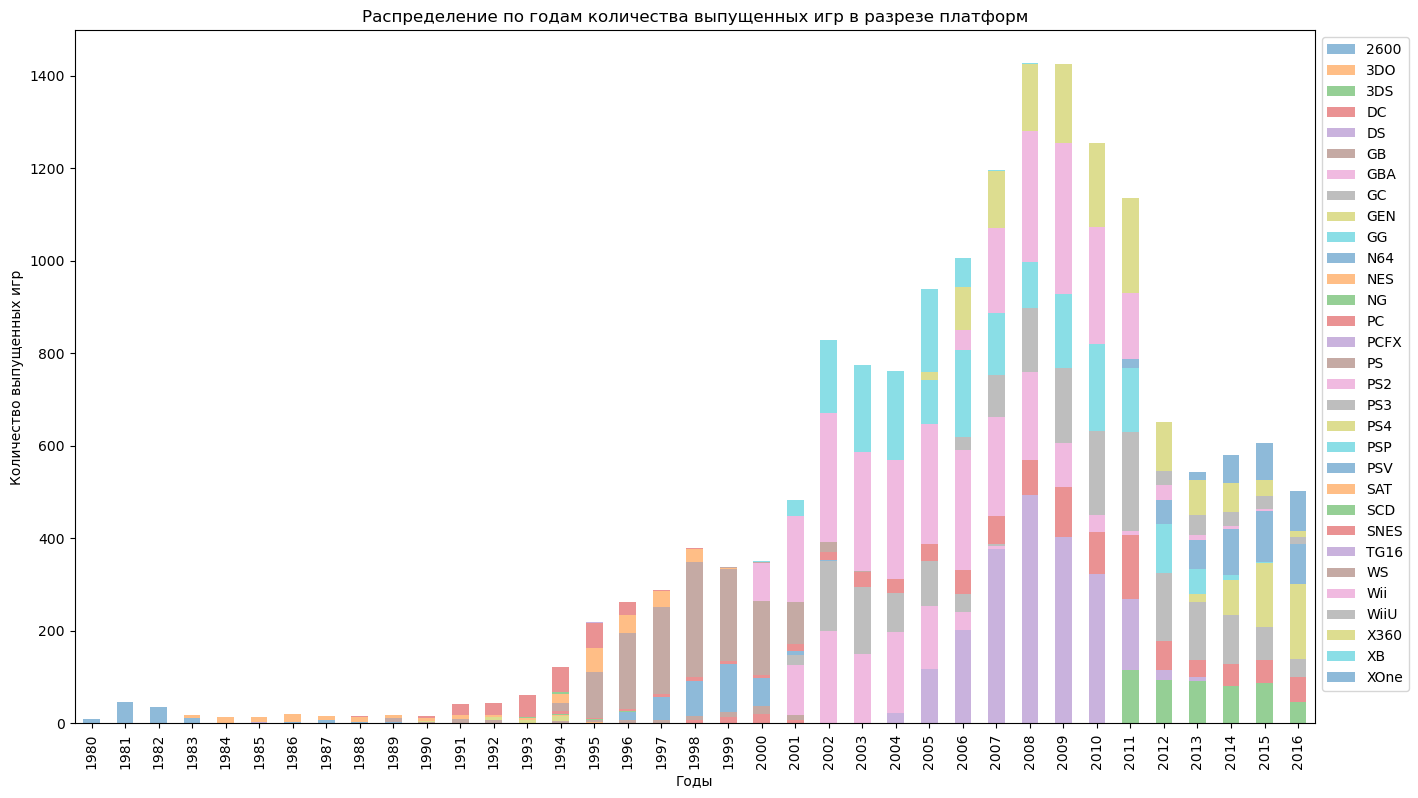

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))

games.pivot_table(index='platform',
              columns='year_of_release',
              values='name',
              aggfunc='count').T.plot(kind='bar',stacked=True, ax=ax, figsize=(16,9), alpha=0.5)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Годы')
ax.set_ylabel('Количество выпущенных игр')
ax.set_title('Распределение по годам количества выпущенных игр в разрезе платформ')

plt.show()

Итак, мы видим, что: 

- наибольшее количество игр выпускалось в промежутке с 2002-го по 2011-й годы;

- наибольшее количество игр выпустили платформы PS2 и PS3 (производитель Sony),  DS и Wii (производитель Nintendo), X360 (производитель Microsoft);

- есть платформы, которые больше не выпускают игры и наборот, есть активные (на момент выгрузки данных) производители.

С учетом того, что целью данного исследования является выявление закономерности успешных игр, смотреть на данные платформ, которые не выпускали игры продолжительное время, не стоит.

### продажи

In [26]:
games[['platform', 'total_sales']].sort_values(by='total_sales', ascending=False).head(10)

,platform,total_sales
0,Wii,82.54
1,NES,40.24
2,Wii,35.52
3,Wii,32.77
4,GB,31.38
5,GB,30.26
6,DS,29.80
7,Wii,28.91
8,Wii,28.32
9,NES,28.31


Определим ТОП-7 платформ с наибольшими суммарными продажами.

In [27]:
games.groupby('platform').sum()[['total_sales']].reset_index().sort_values(
    by='total_sales', ascending=False
).head(7)

,platform,total_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.33
26,Wii,891.18
4,DS,802.78
15,PS,727.58
18,PS4,314.14


На примере платформ с наибольшими суммарными продажами построим распределение продаж по годам.

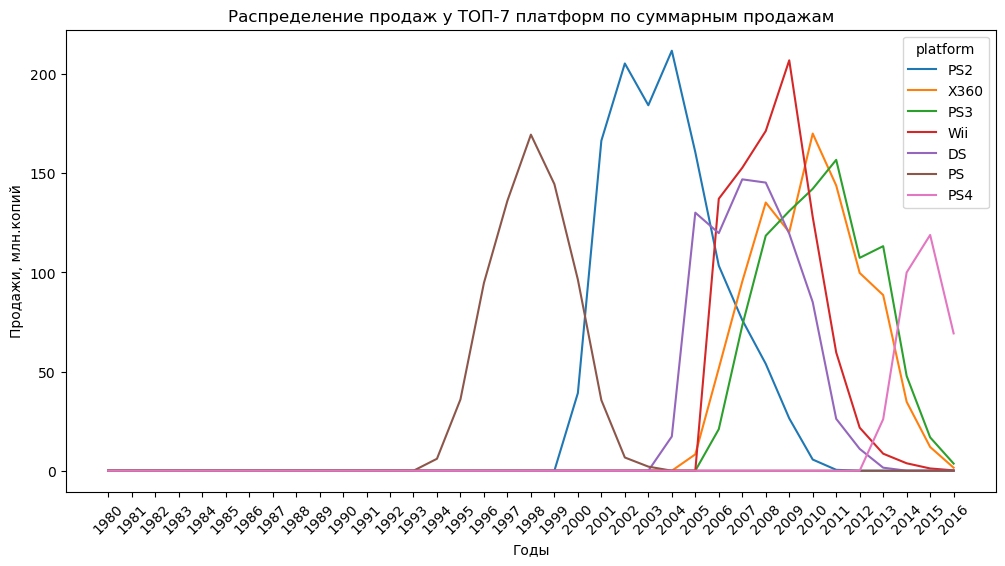

In [28]:
data_top_sales = games.pivot_table(
    index = 'year_of_release', 
    columns = 'platform',
    values = 'total_sales', 
    aggfunc = 'sum'
    ).fillna(0)

data_top_sales = data_top_sales[['PS2', 'X360','PS3','Wii', 'DS', 'PS', 'PS4']]
ax = data_top_sales.plot(xticks=data_top_sales.index,figsize=(12,6))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ylab = ax.set_ylabel('Продажи, млн.копий')
xlab = ax.set_xlabel('Годы')
plt.title('Распределение продаж у ТОП-7 платформ по суммарным продажам')
plt.show()    

Заметно, что цикл появления новых и исчезновения старых платформ составляет примерно 12 лет. Таким образом, для прогнозирования подаж на следующий год нужно использовать данные за последние 5-ть лет: платформы, продажи которых растут в течение этого срока, являются наиболее перспективными (т.к. есть еще пара лет до пика продаж + впереди достаточно большой срок, когда продажи будут падать, но все еще будут приносить достаточно денег).

Давайте посмотрим данные за 2012-2016 гг., чтобы понять, какие платформы окажутся в лидерах.

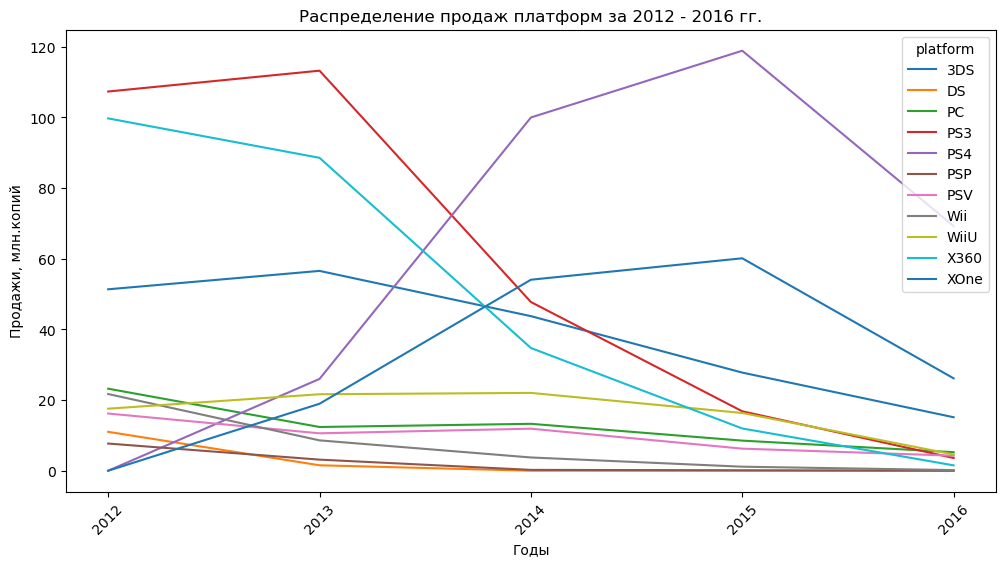

In [29]:
data_sales = games.query('year_of_release >= 2012').pivot_table(
    index = 'year_of_release', 
    columns = 'platform',
    values = 'total_sales', 
    aggfunc = 'sum'
    ).fillna(0)

ax = data_sales.plot(xticks=data_sales.index,figsize=(12,6))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ylab = ax.set_ylabel('Продажи, млн.копий')
xlab = ax.set_xlabel('Годы')
plt.title('Распределение продаж платформ за 2012 - 2016 гг.')
plt.show()   


Итак, самыми потенциально прибыльными платформами являются Sony PlayStation 4 и Xbox One от Microsoft. Какое-то время будут актуальны игры для платформ Nintendo 3DS, Wii U, Xbox 360 и PlayStation 3. Остальные платформы уже упали в продажах и ждать второго дыхания в 2017 году не стоит. Конечно, на графике виден спад абсолютно всех продаж в 2016 году, но возможно это связано с тем, что просто нет полных данных за этот период.

Так же любопытно, что на примере Sony PlayStation 3 и Sony PlayStation (или Xbox One и Xbox 360) можно увидеть смену поколений, когда игры выпускаются как для старой платформы, так и для новой.

### анализ продаж перспективных платформ

Итак, мы с вами определили, что перспективными платформами являются PS4, PS3, XOne, X360, WiiU и 3DS, а актуальный период исследования - 5 лет, т.е. 2012-2016 годы.

Поготовим данные с помощью фильтрации.

In [30]:
games_top = games.query('year_of_release >= 2012 & platform in ["PS4", "XOne", "PS3", "X360", "WiiU", "3DS"]')
games_top.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unrated,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unrated,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


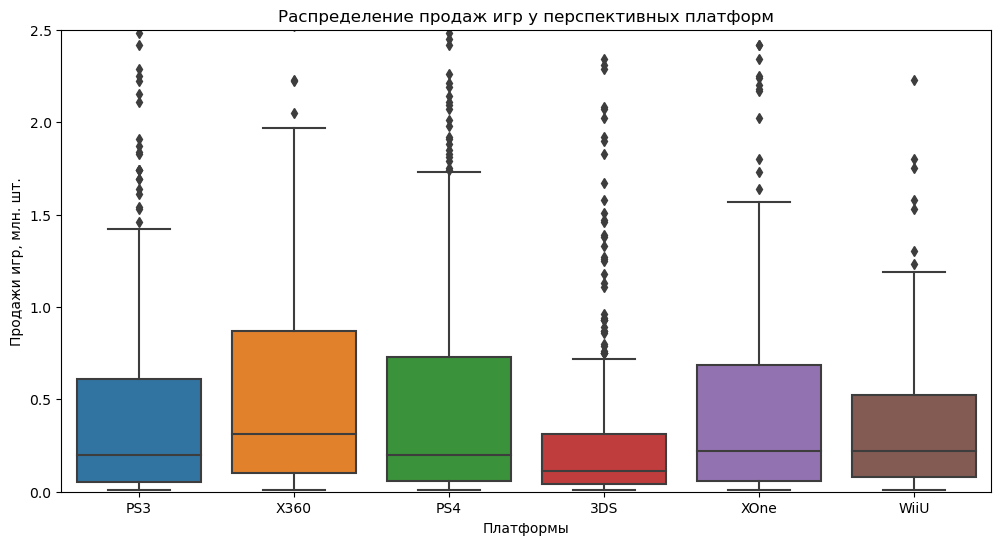

In [31]:
plt.figure(figsize=(12,6))

ax = sns.boxplot(x='platform', y='total_sales', data=games_top)
ax.set_ylim(0, 2.5)
ax.set_ylabel('Продажи игр, млн. шт.')
ax.set_xlabel('Платформы')
ax.set_title('Распределение продаж игр у перспективных платформ')
plt.show()

Медианные значения продаж смещены к нижнему краю – то есть на всех платформах выходит много игр с относительно небольшими продажами. При этом везде есть небольшое количество бестселлеров, продажи которых могут многократно превышать обычные значения.

### влияние отзывов критиков и пользователей

Посмотрим, насколько велико влияние отзывов, как профессиональных критиков, так и обычных пользователей, на продажи платформ.

Вот, например, средние оценки наших перспективных платформ за последние 5 лет. Нельзя сказать, что они очень высокие.

In [32]:
games_top.groupby('platform')[['user_score', 'critic_score']].agg('mean').round(2)

,user_score,critic_score
platform,,
3DS,7.03,69.82
PS3,6.54,71.51
PS4,6.75,72.09
WiiU,6.90,70.73
X360,6.22,70.87
XOne,6.52,73.33


Подсчитаем коэффициент корреляции между глобальными продажами и оценками критиков для платформы PS4.

In [33]:
games_top.query('platform == "PS4"')['total_sales'].corr(games_top.query('platform == "PS4"')['user_score'])

-0.03195711020455643

In [34]:
games_top.query('platform == "PS4"')['total_sales'].corr(games_top.query('platform == "PS4"')['critic_score'])

0.4065679020617816

Визуализируем эти значения при помощи графика рассеивания.

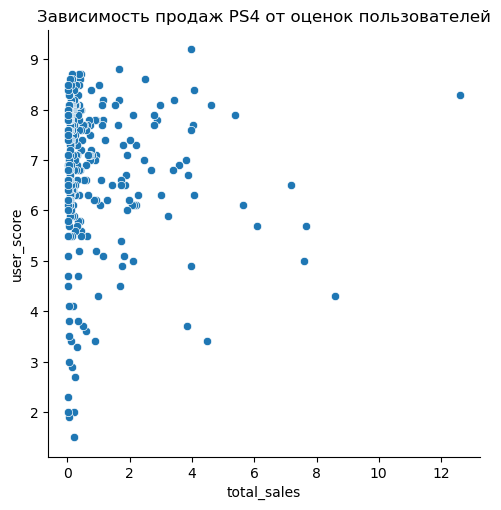

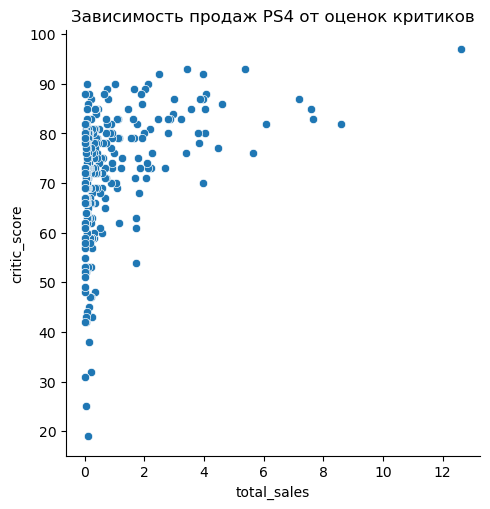

In [35]:
sns.relplot(x='total_sales', y='user_score',data=games_top.query('platform == "PS4"'))
plt.title('Зависимость продаж PS4 от оценок пользователей')
sns.relplot(x='total_sales', y='critic_score',data=games_top.query('platform == "PS4"'))
plt.title('Зависимость продаж PS4 от оценок критиков')
plt.show()

Подсчитаем коэффициент корреляции между глобальными продажами и оценками критиков для платформы XOne.

In [36]:
games_top.query('platform == "XOne"')['total_sales'].corr(games_top.query('platform == "XOne"')['user_score'])

-0.06892505328279415

In [37]:
games_top.query('platform == "XOne"')['total_sales'].corr(games_top.query('platform == "XOne"')['critic_score'])

0.41699832800840164

Прямой зависимости, как ни странно, нет; впрочем, оценки критиков влияют на продажи чуть больше.

Проверим это предположение на всех перспективных платформах.

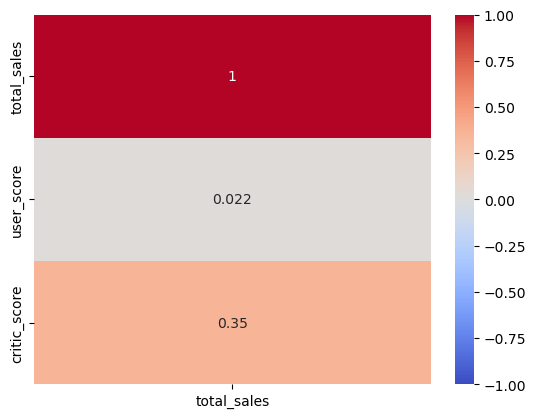

In [38]:
upp_mat = np.triu(games_top[['total_sales','user_score', 'critic_score']].corr())

sns.heatmap(
    games_top[['total_sales','user_score', 'critic_score']].
    corr()[['total_sales']], 
    vmin = -1, 
    vmax = +1, 
    annot = True, 
    cmap = 'coolwarm'
)
plt.show()

Добавим расчет и визуализацию для остальным платформ по отдельности из нашего скоупа.

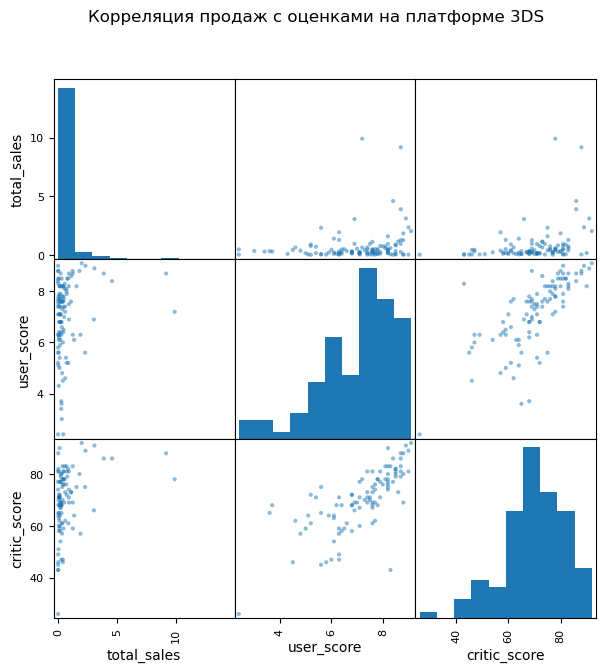

,total_sales,user_score,critic_score
total_sales,1.000000,0.197583,0.320803
user_score,0.197583,1.000000,0.722762
critic_score,0.320803,0.722762,1.000000


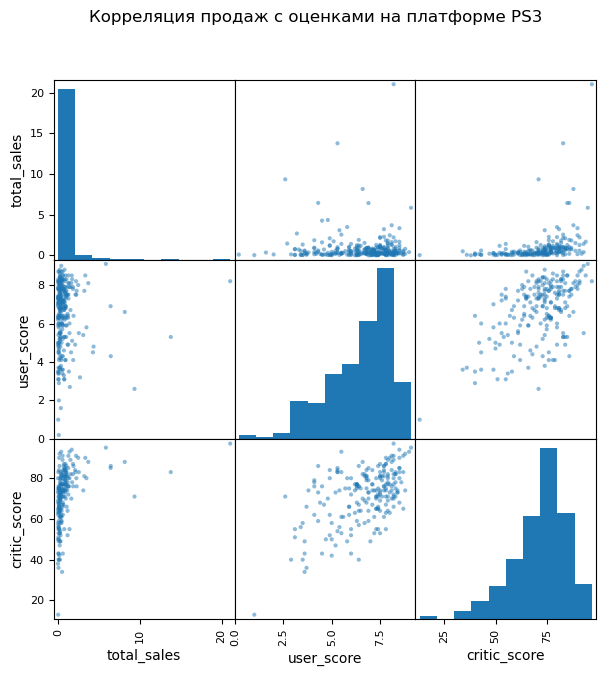

,total_sales,user_score,critic_score
total_sales,1.000000,-0.006206,0.334152
user_score,-0.006206,1.000000,0.544510
critic_score,0.334152,0.544510,1.000000


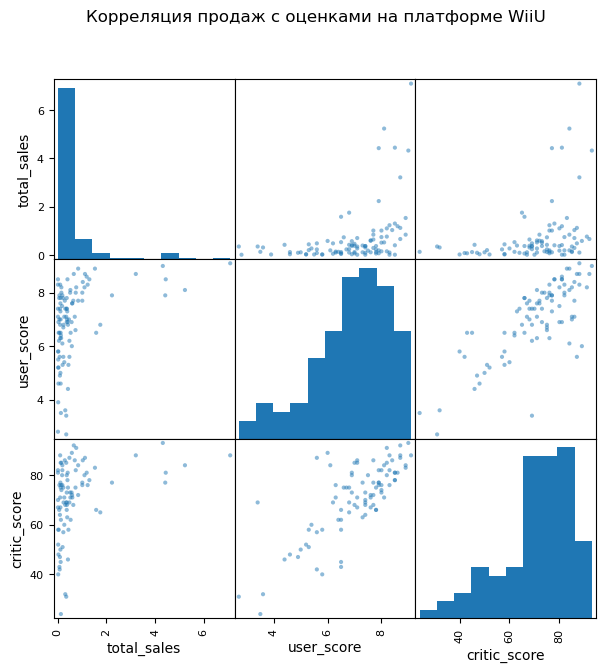

,total_sales,user_score,critic_score
total_sales,1.000000,0.400219,0.34838
user_score,0.400219,1.000000,0.77008
critic_score,0.348380,0.770080,1.00000


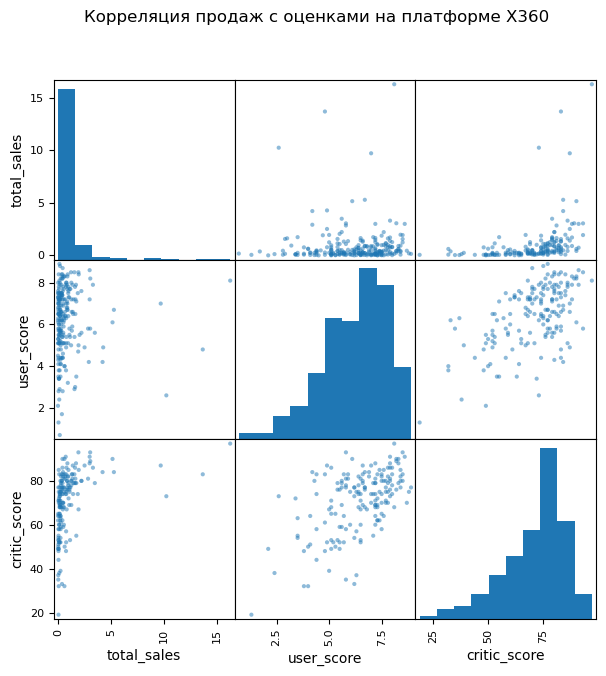

,total_sales,user_score,critic_score
total_sales,1.000000,0.006164,0.360573
user_score,0.006164,1.000000,0.557352
critic_score,0.360573,0.557352,1.000000


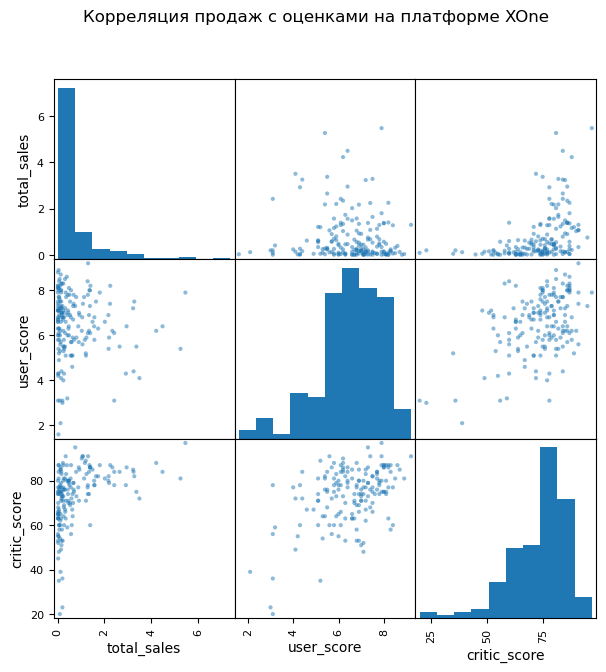

,total_sales,user_score,critic_score
total_sales,1.000000,-0.068925,0.416998
user_score,-0.068925,1.000000,0.472462
critic_score,0.416998,0.472462,1.000000


In [39]:
# рассчитаем коэффициенты корреляции и построим диграммы рассеяния другим способом

platform_list = ['3DS', 'PS3','WiiU', 'X360', 'XOne']

for platform in platform_list:
    data = games_top.query('platform == @platform')[['total_sales','user_score', 'critic_score']]
    
    fig, ax = plt.subplots(figsize = (7,7))
    pd.plotting.scatter_matrix(data, ax=ax)
    fig.suptitle(f'Корреляция продаж с оценками на платформе {platform}')
    plt.show()   
    
    display(games_top.query('platform == @platform')[['total_sales','user_score', 'critic_score']].agg('corr'))
    

Да, нам не показалось, профессиональные критики действительно существуют не зря, но сказать, что от их мнения зависят продажи напрямую, тоже нельзя. Оценки пользователей влияют на продажи еще меньше. 

Но, впрочем, мы наткнулись на исключение:на платформе WiiU (Wii U от Nintendo) отзывы пользователей коррелируют  с продажами больше, чем отзывы критиков.

### жанры игр и продажи

Теперь посмотрим распределение игр по жанрам. Есть ли наиболее прибыльные (или наоборот) жанры? Анализ будем проводить на примере перспективных платформ за последние пять лет выборки.

In [40]:
games_top['genre'].value_counts()

Action          721
Role-Playing    226
Sports          210
Shooter         190
Misc            138
Adventure       136
Fighting         88
Racing           85
Platform         70
Simulation       50
Strategy         33
Puzzle           19
Name: genre, dtype: int64

In [41]:
games_top.pivot_table(
    index = 'genre',
    columns = 'platform',
    values = 'total_sales',
    aggfunc='sum',
    margins=True
).fillna(0).sort_values(
    by='All', 
    ascending=False
)

platform,3DS,PS3,PS4,WiiU,X360,XOne,All
genre,,,,,,,
All,194.61,288.78,314.14,82.19,236.54,159.32,1275.58
Action,45.49,115.75,96.10,19.07,81.60,37.31,395.32
Shooter,0.13,60.39,88.56,6.01,72.70,60.33,288.12
Sports,4.23,44.83,55.61,3.16,36.39,26.74,170.96
Role-Playing,79.30,22.62,28.99,2.89,9.80,10.55,154.15
Misc,9.45,8.88,8.19,12.46,14.83,7.43,61.24
Platform,19.11,4.26,7.69,21.53,2.14,0.93,55.66
Racing,0.28,11.56,12.14,7.87,8.41,9.79,50.05
Fighting,8.46,11.00,8.65,6.27,4.97,2.45,41.80


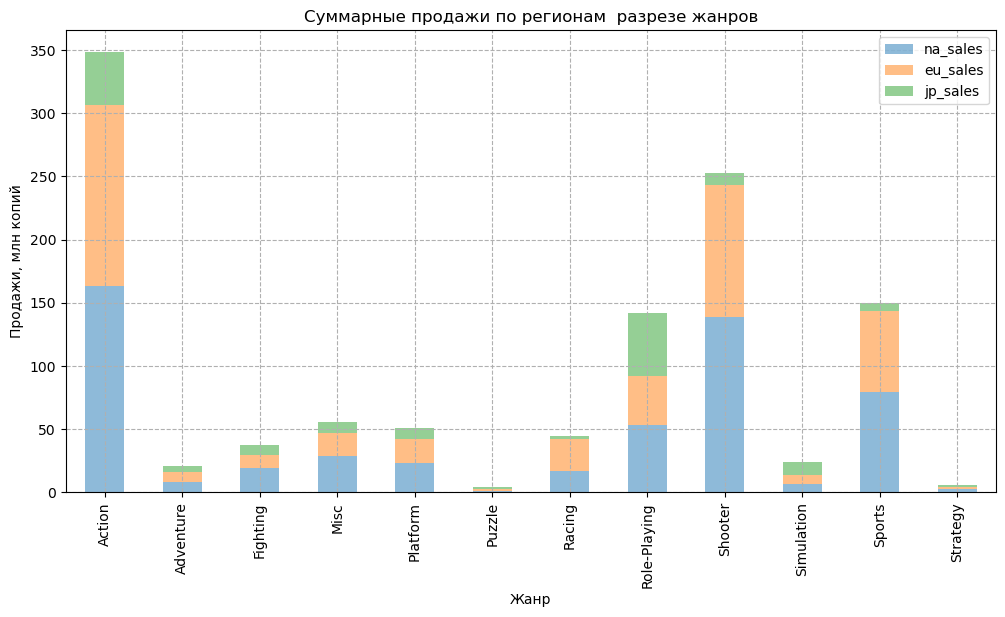

In [42]:
fig, ax = plt.subplots()

(games_top
 .groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']]
 .agg('sum')
 .plot(kind='bar',stacked=True, ax=ax, figsize=(12,6), alpha=0.5))

ax.set_title('Суммарные продажи по регионам  разрезе жанров')
ax.set_ylabel('Продажи, млн копий')
ax.set_xlabel('Жанр')
ax.grid(linestyle='--')
plt.show()

Самыми продаваемыми жанрами в играх являются Action, Shooter и  Sports. 

* `Action` - сущность экшенов отражает их название – в переводе с английского оно означает «действие», и здесь игрок находится в самом центре действия и управляет им. 

* `Shoters` - шутеры позволяют игрокам использовать в своих действиях оружие, обычно с целью уничтожить врагов или противоборствующих игроков. Шутеры делятся по ракурсу обзора игрока (от первого лица, от третьего лица, с обзором сверху)ю

* `Sports` - спортивные игры, как и следует из названия, симулируют различные виды спорта, например, гольф, баскетбол, обычный и американский футбол. Встречаются также олимпийские виды спорта типа лыжных гонок, и даже «барный спорт» вроде бильярда или дартс. 


А вот самые низкие продажи у игр в жанрах Adventure, Strategy и Puzzle.

* `Adventure` - обычно в приключенческих играх пользователи взаимодействуют с другими персонажами и окружающим миром для решения головоломок с подсказками, продвигаясь таким образом по сюжету. Не считая периодических мини-игр, в квестах редко встречаются экшен-элементы. Поэтому среди мейнстримных геймеров жанр не так популярен.

* `Strategy` - геймплей этого жанра уходит своими корнями в традиционные настольные стратегические игры. Часто в этих играх вам доступен целый мир и все его ресурсы, а чтобы справиться с испытаниями, игроку требуется тщательно продумывать стратегию и тактику. 

* `Puzzle` - думаем, что здесь пояснения не нужны.

Нельзя не отметить, что одна из платформ(3DS) достаточно успешно специализируется в жанре `Role-Playing`  (ролевые игры, или RPG; одной из знаковых особенностей жанра является выбор игрока, влияющий на итог игры, то есть у многих RPG есть несколько альтернативных концовок).

Давайте построим аналогичный график для среднего количества продаж.

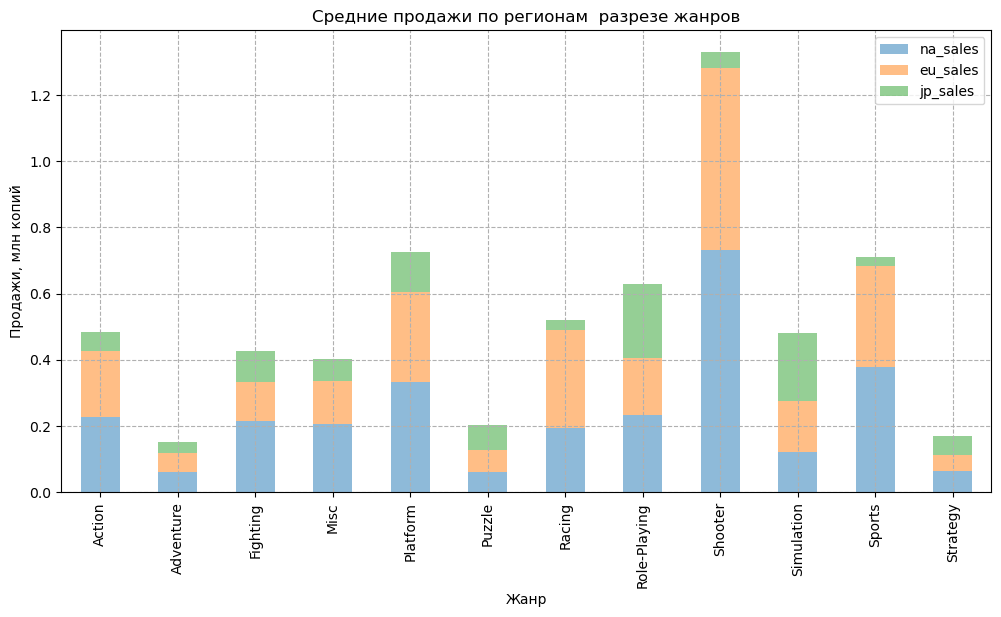

In [43]:
fig, ax = plt.subplots()

(games_top
 .groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']]
 .agg('mean')
 .plot(kind='bar',stacked=True, ax=ax, figsize=(12,6), alpha=0.5))

ax.set_title('Средние продажи по регионам  разрезе жанров')
ax.set_ylabel('Продажи, млн копий')
ax.set_xlabel('Жанр')
ax.grid(linestyle='--')
plt.show()

По среднему количеству продаж мы наблюдаем смещение лидеров: теперь на первом месте по продажам - `Shooters`, а в тройке лидеров появляется жанр `Platform`. `Action` выбыл из топ-5. 

Такой результат говорит нам о том, что этих жанрах есть игры-хиты с многомиллионными продажами.

`Platform` - вид аркад, в которых нужно, управляя героем, ходить, бегать и запрыгивать на разные платформы (или возвышенности), в большинстве случаев, нейтрализуя или избегая врагов, и собирать различные бонусы.


## Исследование продаж в разрезе рынков

### популярные платформы  и жанры

Давайте определим для каждого региона (EU, NA и JP) самые популярные платформы. Для этого подсчитаем долю продаж за последние 5-ть лет.

In [44]:
games_top.pivot_table(
    index = 'platform',
    values = ['na_sales', 'eu_sales', 'jp_sales'],
    aggfunc =  'sum'
).apply(
    lambda col: col / col.sum(), 
    axis=0
).style.format("{:.1%}")

,eu_sales,jp_sales,na_sales
platform,,,
3DS,9.7%,57.0%,10.3%
PS3,24.2%,22.9%,19.2%
PS4,31.9%,10.4%,20.2%
WiiU,5.7%,8.5%,7.1%
X360,16.9%,1.0%,26.0%
XOne,11.7%,0.2%,17.3%


Мы видим разницу в предпочтениях визуально: европейские пользователи предпочитают Sony PlayStation (более 55% рынка), американские - Microsoft XBox (более 43% рынка), японские геймеры голосуют деньгами за Nintendo 3DS(57%).

In [45]:
games_top.pivot_table(
    index = 'genre',
    values = ['na_sales', 'eu_sales', 'jp_sales'],
    aggfunc =  'sum'
).apply(
    lambda col: col / col.sum(), 
    axis=0
).style.format("{:.1%}")

,eu_sales,jp_sales,na_sales
genre,,,
Action,32.4%,27.3%,30.3%
Adventure,1.8%,2.8%,1.5%
Fighting,2.3%,5.5%,3.5%
Misc,4.1%,5.9%,5.3%
Platform,4.3%,5.6%,4.3%
Puzzle,0.3%,0.9%,0.2%
Racing,5.7%,1.6%,3.1%
Role-Playing,8.8%,32.7%,9.8%
Shooter,23.7%,5.9%,25.8%


В распределении долей рынка по жанрам у пользователей Америки и Европы вкусы совпадают  по первым четырем пунктам из ТОП5: Action -> Shooters -> Sports -> Role_playing. А вот на пятой строчке в Европе гонки, в то время как у жителей Северной Америки - Misc (от англ. Miscellaneuos = разное или прочее).

У японцев все иначе: Role-Playing -> Action -> Simulation -> Shooters и Misc.

Если подвести итоги, то:

* в Северной Америке  самая большая доля рынка от глобальных продаж, а самые продаваемые платформы принадлежат местному производителю Microsoft;

* Европа второй по величине рынок; абсолютным лидером среди платформ является Sony Playstation;Европа и Северная Америка похожи – главные жанры Action, шутеры и спорт;

* Япония занимает третье место по продажам; рынок не похож на остальные: местные производители целиком и полностью доминируют по продажам, оставив остальным производителям всего около 1% рынка; в жанровых препочтениях Япония – единственный рынок, где предобладает RPG. 

### влияние рейтинга ESRB на продажи

In [46]:
games_top.pivot_table(
    index = 'rating',
    values = ['na_sales', 'eu_sales', 'jp_sales'],
    aggfunc =  'sum'
).apply(
    lambda col: col / col.sum(), 
    axis=0
).style.format("{:.1%}")

,eu_sales,jp_sales,na_sales
rating,,,
E,23.1%,17.3%,20.2%
E10+,9.6%,4.9%,11.1%
M,39.4%,12.5%,40.1%
T,9.8%,13.0%,10.8%
unrated,18.2%,52.3%,17.8%


Первое, что бросается в глаза: половина игр японского рынка -  без рейтинга. Возможно, он не требуется для локальных игр, или, как вариант, устанавливаетcя другой организацией (не ESBP).

Так же, мы понимает, что некоторые жанры (например, шутеры) могут иметь более высокое ограничение по возрасту. 

## Проверка гипотез

В ходе анализа необходимо проверить две гипотезы:

- Средние пользовательские рейтинги платформ Xbox One  и PC одинаковые;

- Средние пользовательские рейтинги жанров Action (англ. "действие", экшен-игры) и Sports(англ. "спортивные соревнования") разные.

### пользовательские рейтинги платформ Xbox One  и PC

Подсчитаем оценки за полный период (т.к. не было указаний, что нужно брать сопоставимые периоды или актуальный период).

In [47]:
display(games.query('platform in ["XOne", "PC"]').pivot_table(index='platform', values='user_score'))

# удаляем пропуски

xone = games.query('platform == "XOne"').user_score.dropna().reset_index(drop=True)
pc = games.query('platform == "PC"').user_score.dropna().reset_index(drop=True)

,user_score
platform,
PC,7.065960
XOne,6.521429


In [48]:
def hist(data, title_1, title_2):    # напишем фунцию для построения графиков
    
    data.hist(bins=50, range=(0,10))
    plt.title(title_1, loc='left')
    plt.show()
    
    sns.distplot(data)
    plt.title(title_2, loc='left')
    plt.show()

In [49]:
xone.describe()

count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

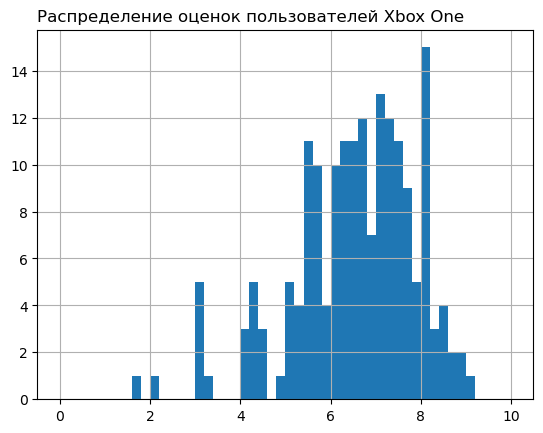

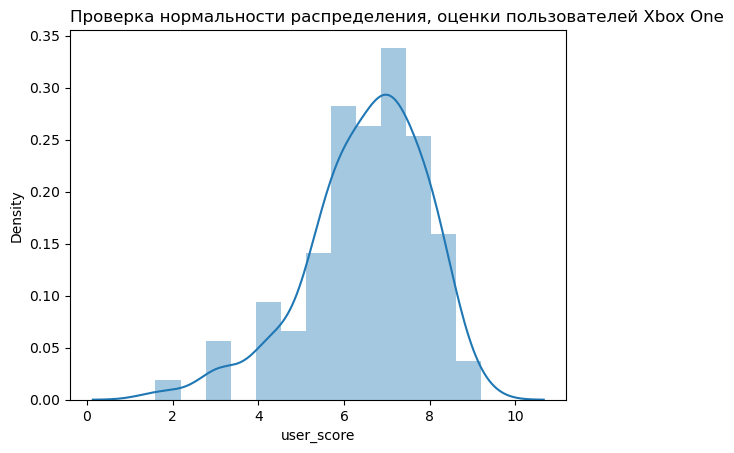

In [50]:
hist(
    xone, 
    'Распределение оценок пользователей Xbox One',
    'Проверка нормальности распределения, оценки пользователей Xbox One'
)

In [51]:
pc.describe()

count    755.000000
mean       7.065960
std        1.532718
min        1.400000
25%        6.200000
50%        7.500000
75%        8.200000
max        9.300000
Name: user_score, dtype: float64

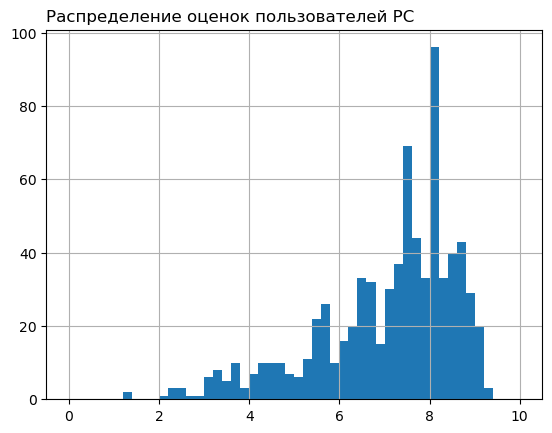

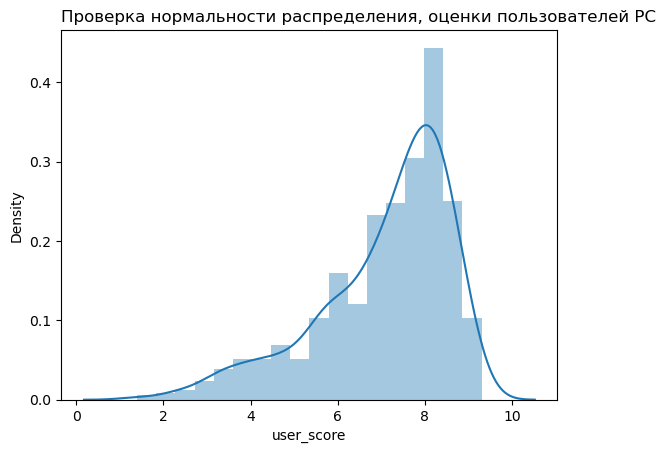

In [52]:
hist(
    pc, 
    'Распределение оценок пользователей PC',
    'Проверка нормальности распределения, оценки пользователей PC'
)

Оценок игр на PC намного больше, они более сбалансированы и сгруппированы ( в промежутке от 7 до 9 баллов), и, глядя на графики, кажется, что оценки различаются. Давайте это проверим.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{средние пользовательские рейтинги Xbox One и PC одинаковы}\\
   H_1 :\text{средние пользовательские рейтинги Xbox One и PC различаются}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$ 

Посчитаем p-value, используя `ttest` из библиотеки `scipy` для сравнения средних двух выборок.

У нас разные по размеру выборки (отзывов пользователей PC в четыре раза больше, чем пользователей платформы XOne).
Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод `st.stats.ttest_ind`, так же мы будем использовать параметр `equal_var=False`, т.к. есть сомнения по разночначности выборок.

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [53]:
alpha = .05 # критический уровень статистической значимости

results = st.stats.ttest_ind(xone, pc, equal_var=False)
print('p-значение: ', results.pvalue)    # тест двухсторонний
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.5385802963771835e-06
Отвергаем нулевую гипотезу


Различие средних значений статистически значимо: средние пользовательские рейтинги Xbox One и PC различаются.

### пользовательские рейтинги жанров Action и Sports

По аналогии с действиями выше берем оценки за весь период.

In [54]:
display(games.query('genre in ["Action", "Sports"]').pivot_table(index='genre', values='user_score'))

# удаляем пропуски

action = games.query('genre == "Action"').user_score.dropna().reset_index(drop=True)
sports = games.query('genre == "Sports"').user_score.dropna().reset_index(drop=True)

,user_score
genre,
Action,7.058129
Sports,6.952778


In [55]:
action.describe()

count    1796.000000
mean        7.058129
std         1.423901
min         0.300000
25%         6.300000
50%         7.400000
75%         8.100000
max         9.500000
Name: user_score, dtype: float64

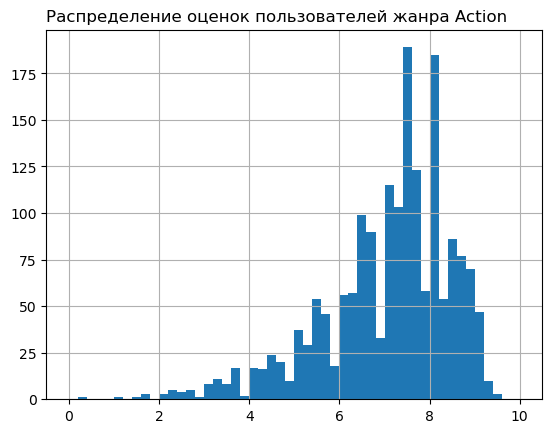

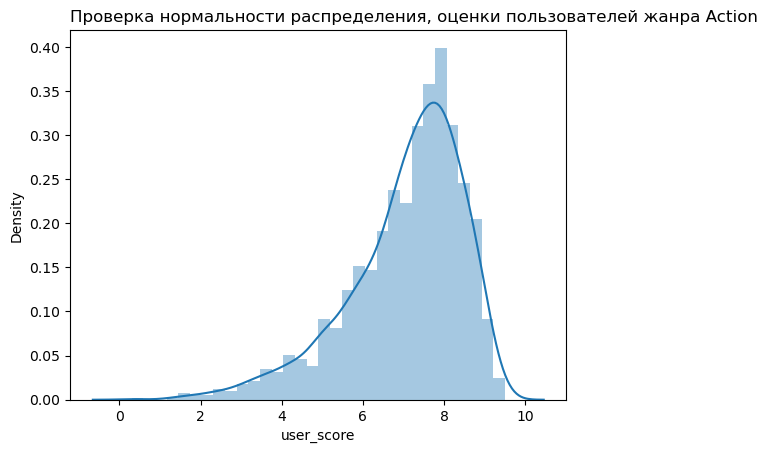

In [56]:
hist(
    action, 
    'Распределение оценок пользователей жанра Action',
    'Проверка нормальности распределения, оценки пользователей жанра Action'
)

In [57]:
sports.describe()

count    1080.000000
mean        6.952778
std         1.619732
min         0.200000
25%         6.100000
50%         7.400000
75%         8.100000
max         9.500000
Name: user_score, dtype: float64

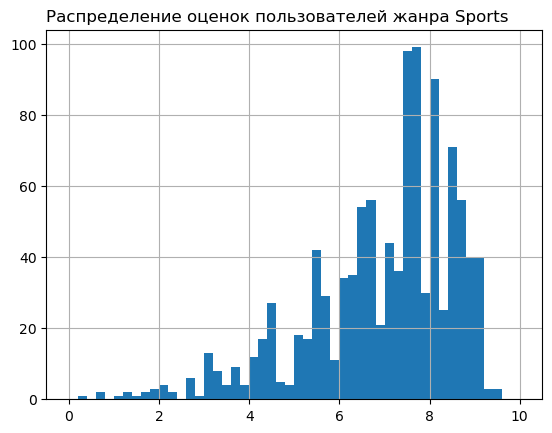

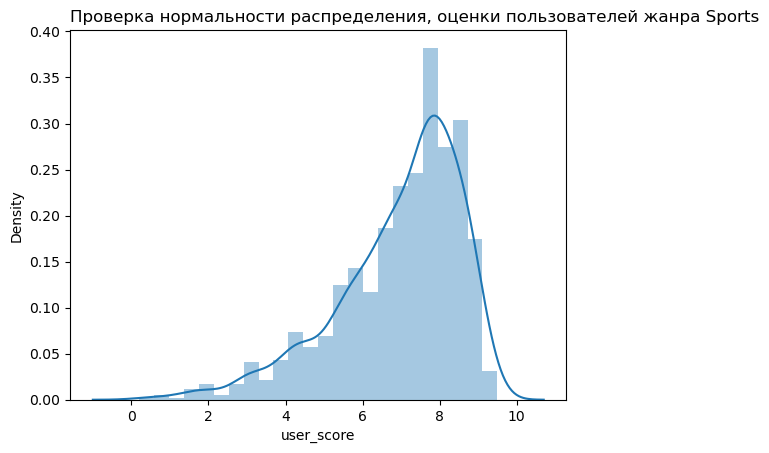

In [58]:
hist(
    sports, 
    'Распределение оценок пользователей жанра Sports',
    'Проверка нормальности распределения, оценки пользователей жанра Sports'
)

В отличие от предыдущего случая и выборки, и распределения кажутся очень похожими.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{средние пользовательские рейтинги жанров Action и Sports одинаковы}\\
   H_1 :\text{средние пользовательские рейтинги жанров Action и Sports различаются}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$ 

Посчитаем p-value, используя `ttest` из библиотеки `scipy` для сравнения средних двух выборок.

У нас разные по размеру выборки (отзывов пользователей PC в четыре раза больше, чем пользователей платформы XOne).
Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод `st.stats.ttest_ind`, так же мы будем использовать параметр `equal_var=True`.

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [59]:
alpha = .05 # критический уровень статистической значимости

results = st.stats.ttest_ind(action, sports, equal_var=False)

print('p-значение: ', results.pvalue)    # тест двухсторонний
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.07751671595536253
Не получилось отвергнуть нулевую гипотезу


Нам не показалось: различие средних значений пользовательских оценок игр двух жанров статистически не значимо.

## Вывод

Итак, на основе исторических данных о продажах игр за 2016 нам необходимо было выявить закономерности, определяющие успешность игр.

В ходе исследования мы сделали следующие выводы:

* самыми потенциально прибыльными платформами являются Sony PlayStation 4 и Xbox One от Microsoft. Какое-то время будут актуальны игры для платформ Nintendo 3DS;

* если делить по рынкам, то в Америке следует сделать ставку на игры платформы Xbox One, в Европе - на PS4, а в Японии  - на 3DS;

* из жанров мы рекомендуем выбрать игры в стиле Action,Shoters и Sports (а вот для японского рынка любимым жанром является Role-Playing);

* оценки пользователей на продажи не влияют, а вот к оценкам критиков можно и приглядется (но, в общем и целом, корреляци с продажами даже у этих оценок не очень сильная).

Так же, мы проверили две гипотезы, заявленные в самом начале исследования. В результате этого:

* средние пользовательские рейтинги Xbox One и PC различаются (различие средних значений статистически значимо); 

* гипотеза о различии средних значений пользовательских оценок игр двух жанров Action и Sports не была отвергнута.